In [1]:
import os
import pandas as pd

# Set the folder path
folder_path = '../data/processed/parsed_files/'

# List all pickle files in the folder
pickle_files = [f for f in os.listdir(folder_path) if f.endswith('.pkl')]

# Load and collect all DataFrames
df_articles = pd.DataFrame()
for file in pickle_files:
    file_path = os.path.join(folder_path, file)
    try:
        df = pd.read_pickle(file_path)
        df_articles = pd.concat([df_articles, df])
    except Exception as e:
        print(f"Failed to load {file}: {e}")


# Optionally save the result
# combined_df.to_pickle('/path/to/save/combined.pkl')


In [2]:
df_articles.shape

(41861, 8)

In [4]:
print(f"Number of files: {len(set(df_articles["source_file"]))}")

Number of files: 84


## 1. Repeated Titles

In [13]:
anomalous_titles = {key:value for key, value in dict(df_articles['title'].value_counts()).items() if value > 100}
anomalous_titles

{'No Headline In Original': np.int64(101), 'Movie guide': np.int64(101)}

In [14]:
df_no_headline = df_articles.loc[df_articles["title"] == "No Headline In Original"]
df_no_headline

,title,publisher,date,section,length,body,correction_appended,source_file
446,No Headline In Original,The New York Times,2024-09-01,Section MB; Column 0; Metropolitan Desk; Pg. 3...,533 words,"In the Schools: Dress Codes, Self-Expression a...",False,55.DOCX
457,No Headline In Original,The New York Times,2022-01-30,Section MB; Column 0; Metropolitan Desk; Pg. 3...,774 words,"How Fire Defined the Bronx, and UsReaders resp...",False,55.DOCX
460,No Headline In Original,The New York Times,2021-07-11,Section MB; Column 0; Metropolitan Desk; Pg. 3...,686 words,When New York Was Ours AloneReaders responded ...,False,55.DOCX
263,No Headline In Original,The New York Times,2009-10-22,Section A; Column 0; Metropolitan Desk; Pg. 30...,514 words,"TAKING QUESTIONS This week on the blog, Josh...",False,56.361.DOCX
264,No Headline In Original,The New York Times,2019-05-19,Section MB; Column 0; Metropolitan Desk; Pg. 3...,686 words,No End to the Abuse of Evelyn NesbitThe magazi...,False,56.361.DOCX
...,...,...,...,...,...,...,...,...
356,No Headline In Original,The New York Times,2011-04-03,Section AR; Column 0; Arts and Leisure Desk; P...,142 words,Here's a sampling of readers' responses to Dan...,False,56.361.DOCX
357,No Headline In Original,The New York Times,1996-01-11,Section A;; Section A; Page 2; Column 6; Metro...,46 words,"""It's not the process that Senator Helms objec...",False,56.361.DOCX
358,No Headline In Original,The New York Times,2008-06-22,Section SP; Column 0; Sports Desk; Pg. 10; OUT...,161 words,The five most e-mailed articles from nytimes.c...,False,56.361.DOCX
359,No Headline In Original,The New York Times,1986-06-11,"Section B; Page 1, Column 6; Metropolitan Desk...",40 words,''The Celtics mean everything to Boston. They ...,False,56.361.DOCX


In [15]:
print(df_no_headline['body'].iloc[0])

In the Schools: Dress Codes, Self-Expression and InequityReaders responded by letter and at nytimes.com to Ginia Bellafante's Big City column on Aug. 18 about student dress codes and whether school uniforms should be required. Comments were edited.   I grew up in a working-class family, only ever had thrift store clothes, and was a social pariah because of that. Now my kid attends a New York City charter school where uniforms are required. I love it. The uniform completely removes any sense of ever having the ''wrong'' clothes, which I can attest from personal experience means that a major distraction is just completely removed from the day's equation. There's still some room for personal expression. There are dress, skirt, pants and shorts options, and two possible colors of shirts.  Emily St. John Mandel, New York  Every new school year, we grapple with how to make sure that our students are mindful, respectful and safe while maintaining independence and self-expression. This year br

__Questions for team__

* "No Headline In Original" sometimes appear as the actual title in the raw data. However, the first paragraph in the article's body appear to be the title: take this item in the cleaning steps?

* Review other more common titles (appearing more than 20 times)

## Missing "working class" keywords

In [20]:
def clean_body(text):
    if isinstance(text, str):
        return (text
                .replace("  ", " ")
                .replace(" -", "-")
                .replace("- ", "-")
                .replace("-\xad", "-")
                .replace("‑", "-")
                .replace("-/", "-")
                .replace("-\n", "-"))
    return text  # Leave non-strings (e.g., NaN) unchanged

df_articles['body_cleaned'] = df_articles['body'].apply(clean_body)

In [32]:
df_missing_working_class = df_articles[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) and ('(working) class' not in str(i).lower()) for i in df_articles['body_cleaned']]]
df_missing_working_class = df_missing_working_class[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) for i in df_missing_working_class['title']]]

df_missing_working_class.head(2)

,title,publisher,date,section,length,body,correction_appended,source_file,body_cleaned
423,"Desperate Years: To Be Young, British and Lack...",The New York Times,2013-12-19,MOVIES,616 words,For today’s socially conscious British filmmak...,False,23.DOCX,For today’s socially conscious British filmmak...
466,The G.O.P. Can Avoid A Disaster,The New York Times,2018-04-05,Section A; Column 0; Editorial Desk; Pg. 27; O...,1204 words,With Democrats winning in normally deep red pl...,False,23.DOCX,With Democrats winning in normally deep red pl...


In [33]:
# percetnage time missing
fraction_missing = (df_missing_working_class.shape[0]) / df_articles.shape[0]
if fraction_missing > 0:
    print("Data issue: {}% of articles don't include the working class keyworks.".format(round(fraction_missing*100,2)))
else:
    print("Issue resolved.")

Data issue: 0.62% of articles don't include the working class keyworks.


In [50]:
df_missing_working_class["title"].iloc[1]

'The G.O.P. Can Avoid A Disaster'

In [51]:
print(df_missing_working_class["body_cleaned"].iloc[1])

With Democrats winning in normally deep red places like Alabama and Pennsylvania's 18th Congressional District, it looks like a blue wave is swelling for the midterm elections.There's still time for Republicans to change that, but first they must figure out how to mount an effective defense. To do that, they need to focus on a largely overlooked group of voters: Donald Trump voters who did not like him.  According to the 2016 exit polls, 18 percent of Americans did not like either Mr. Trump or Hillary Clinton. Mr. Trump owes his victory to the fact that he beat her among this group by a 17-point margin, 47 percent to 30 percent (the remainder voted for a third party or write-in candidate). Multiplying Mr. Trump's percentage among this group by the group's share of the electorate yields a startling fact: Nearly one-fifth of all Trump voters didn't like him. This is a shockingly high share; it goes a long way toward explaining why places that voted for Mr. Trump in 2016 could be voting a

In [52]:
print(df_missing_working_class["source_file"].iloc[1])

23.DOCX


__Question for team__

* See example above with team (23.DOCX): 'The G.O.P. Can Avoid A Disaster'. interesting anomaly: "working-class" appears out of body and title. what to do with these cases?

### Check dates

In [62]:
df_missing_dates = df_articles.loc[df_articles['date'].isna()]
df_missing_dates.shape

(195, 9)

In [63]:
df_missing_dates.head()

,title,publisher,date,section,length,body,correction_appended,source_file,body_cleaned
222,The Immigration Bidding War,The New York Times Blogs,NaN,OPINION,1400 words,Hillary Clinton's big immigration speech earli...,False,22.DOCX,Hillary Clinton's big immigration speech earli...
407,Is Greater Focus on the Superrich Right for Th...,The New York Times Blogs,NaN,OPINION,611 words,"To some, it seems counterintuitive to cover th...",False,22.DOCX,"To some, it seems counterintuitive to cover th..."
420,Newsroom Diversity: Why We Should Care,The New York Times Blogs,NaN,OPINION,626 words,Does it matter who reports the news and commen...,False,22.DOCX,Does it matter who reports the news and commen...
438,Clinton Recruits Supporters With 'House Parties',The New York Times Blogs,NaN,US; politics,569 words,DES MOINES - Fresh off her first major campaig...,False,22.DOCX,DES MOINES-Fresh off her first major campaign ...
490,Watch Trailers for ABC's New Dramas and Comedies,The New York Times Blogs,NaN,ARTS,622 words,"This week, in the annual tradition known as t...",False,22.DOCX,"This week, in the annual tradition known as t..."


In [65]:
df_missing_dates['title'].iloc[1]

'Is Greater Focus on the Superrich Right for The Times?'

In [67]:
df_missing_dates["publisher"].value_counts()

publisher
The New York Times Blogs          146
The New York Times                 41
Star Tribune (Minneapolis, MN)      3
Dayton Daily News (Ohio)            2
February 1, 2007 Thursday           1
Chicago Daily Herald                1
The New York Times                  1
Name: count, dtype: int64

In [83]:
df1 = df_missing_dates.loc[df_missing_dates["publisher"] == "Star Tribune (Minneapolis, MN)"]
df1

,title,publisher,date,section,length,body,correction_appended,source_file,body_cleaned
393,"Evenly divide, mostly undecided;\nMost DFL vot...","Star Tribune (Minneapolis, MN)",NaN,NEWS; Minnesota Poll; Pg. 1A,2035 words,DFL voters start off this summer's primary ...,False,Files (500) (30).DOCX,DFL voters start off this summer's primary ...
290,Cleveland says Riverside buyer was right outfi...,"Star Tribune (Minneapolis, MN)",NaN,BUSINESS; On business; Pg. 1D,1224 words,"Dave Cleveland, the indefatigable force beh...",False,Files (500) (28).DOCX,"Dave Cleveland, the indefatigable force beh..."
323,Kidwell pushing Carlson School toward top 10 i...,"Star Tribune (Minneapolis, MN)",NaN,BUSINESS; ON BUSINESS; Pg. 1D,1078 words,Dave Kidwell & Co. had raised nearly $...,False,Files (500) (27).DOCX,Dave Kidwell & Co. had raised nearly $...


In [69]:
df_missing_dates.loc[df_missing_dates["publisher"] == "The New York Times"]

,title,publisher,date,section,length,body,correction_appended,source_file,body_cleaned
169,McMillan's Millions,The New York Times,NaN,Section 6;; Section 6; Page 20; Column 1; Maga...,3387 words,"I'VE HAD 1,500 PEOPLE SHOW UP for a reading fo...",False,55.DOCX,"I'VE HAD 1,500 PEOPLE SHOW UP for a reading fo..."


In [73]:
parsed_dates = pd.to_datetime(df_articles["date"]).dt.date
parsed_dates = parsed_dates[~parsed_dates.isna()]

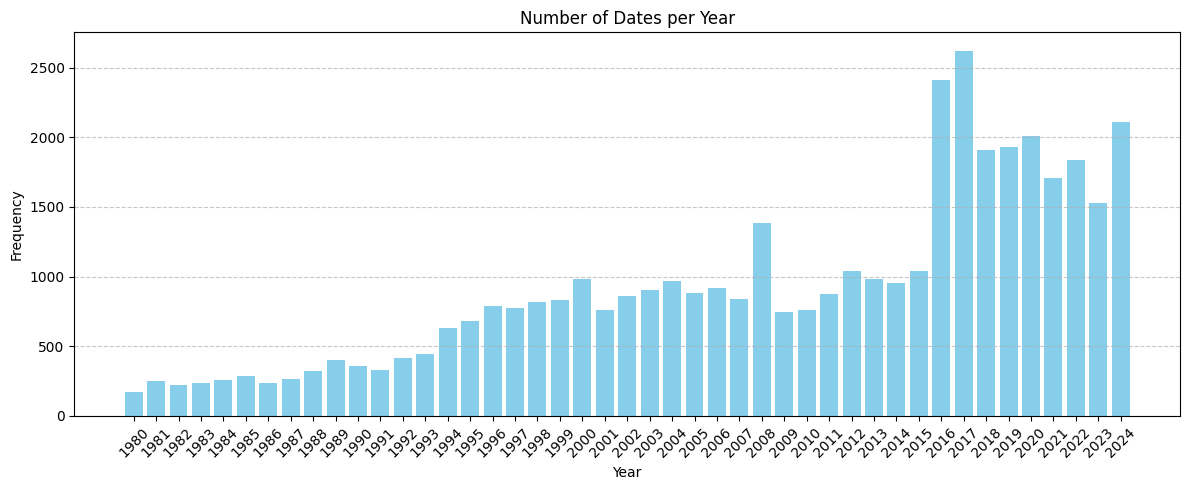

In [80]:
import matplotlib.pyplot as plt
from collections import Counter

# Group by year
years = [d.year for d in parsed_dates]
year_counts = Counter(years)

# Sort by year
sorted_years = sorted(year_counts)
frequencies = [year_counts[year] for year in sorted_years]

# Plot
plt.figure(figsize=(12, 5))
plt.bar(sorted_years, frequencies, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of Dates per Year')
plt.xticks(sorted_years, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### Other

In [40]:
set(df_articles["publisher"])

{' Philadelphia Inquirer',
 ' The New York Times',
 ' The Philadelphia Inquirer',
 'Chicago Daily Herald',
 'Dayton Daily News (Ohio)',
 'February 1, 2007 Thursday',
 'Pittsburgh Post-Gazette',
 'Pittsburgh Post-Gazette (Pennsylvania)',
 'Star Tribune',
 'Star Tribune (Minneapolis, MN)',
 'The New York Times',
 'The New York Times ',
 'The New York Times Blogs ',
 'The New York Times\xa0',
 'The Philadelphia Inquirer',
 'USA TODAY',
 'USA Today'}

In [86]:
df_articles["correction_appended"].value_counts()

correction_appended
False    41641
True       220
Name: count, dtype: int64